In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import seaborn as sns
import datetime 
import scipy.stats as st
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMRegressor

In [2]:
TRAIN_DATA_PATH = 'train.csv'
TEST_DATA_PATH = 'test.csv'
#PREPARED_TRAIN_DATA_PATH = '\prepared_data\prepared_train.csv'
#PREPARED_TEST_DATA_PATH = '\prepared_data\prepared_train.csv'

df = pd.read_csv(TRAIN_DATA_PATH)
y_train = df['Price']
X_train = df.drop('Price', axis=1)
X_test = pd.read_csv(TEST_DATA_PATH)

preds_final = pd.DataFrame()
preds_final['Id'] = X_test['Id'].copy()

print('строк в трейне ', X_train.shape[0])
print('строк в тесте ', X_test.shape[0])

#del df
gc.collect()

строк в трейне  10000
строк в тесте  5000


28

In [3]:
X_train['DistrictId'] = X_train['DistrictId'].astype(str)
X_test['DistrictId'] = X_test['DistrictId'].astype(str)
X_train.set_index('Id', inplace=True)
X_test.set_index('Id', inplace=True)

## Dataset Cleaning 

In [4]:
class DataClean:
    
    def __init__(self):
        self.medians = None
        self.means = None
        self.quantile_999 = None
        self.std = None
        self.districtIdYearMedain = None
        self.KitchenSquareMedian = None
        self.lr_lifesquare_square = None
        self.lr_Kitchensquare_square = None
        self.HealtCare_1_median_by_districtId = None
        self.SquareDownBound = None
        self.SquareUpBound = None
        self.SquareCleaningCondition = None
        
    def fit(self, X):
        self.medians = X.median()
        self.mean = X.mean()
        self.quantile_999 = X.quantile(q=0.999)
        self.std = X.std()
        self.house_year_group_by_distId_medians = dict(X.groupby('DistrictId')['HouseYear'].median())
        self.HealtCare_1_median_by_districtId = dict(X.groupby('DistrictId')['Healthcare_1'].median())
        
        self.SquareUpBound = 200
        self.SquareDownBound = 20
        
        self.SquareCleaningCondition = (X['Square'] < self.SquareDownBound) | ((X['Square'] > self.SquareUpBound) & \
                                  (X['Square'] > (self.medians['Square']/self.medians['Rooms'])*X['Rooms'] + 2*self.std['Square']))
        
        # изпользую линейную регрессию для заполнения пропусков и выбросов в KithcenSquare и LifeSquare
        self.lr_Kitchensquare_square = LinearRegression()
        self.lr_Kitchensquare_square.fit(np.array(X.loc[(~X['KitchenSquare'].isna()) & ~self.SquareCleaningCondition, 'Square']).reshape(-1, 1), \
                                         X.loc[(~X['KitchenSquare'].isna()) & ~self.SquareCleaningCondition, 'KitchenSquare'])
          
        self.lr_lifesquare_square = LinearRegression()
        self.lr_lifesquare_square.fit(np.array(X.loc[(~X['LifeSquare'].isna()) & ~self.SquareCleaningCondition, 'Square']).reshape(-1, 1), \
                                      X.loc[(~X['LifeSquare'].isna()) & ~self.SquareCleaningCondition, 'LifeSquare'])
        
         
    def transform(self, X, y=None):
        
        #Rooms
        X['Rooms_outlier'] = 0
        X.loc[((X['Rooms'] > 5) & (X['Square'] < ((self.medians['Square']/self.medians['Rooms'])*X['Rooms'] - 2*self.std['Square']))) | (X['Rooms'] == 0), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = np.ceil(X['Square']/(self.medians['Square']/self.medians['Rooms'] + 0.5*self.std['Square']))
        X.loc[(X['Rooms'] > 5) & (X['Square'] < ((self.medians['Square']/self.medians['Rooms'])*X['Rooms'] - 2*self.std['Square'])), 'Rooms'] = np.ceil(X['Square']/self.medians['Square']) 
        
        #Square
        down_bound = 36
        X['Square_outlier'] = 0
        condition = (X['Square'] < self.SquareDownBound) | ((X['Square'] > self.SquareUpBound) & \
                                  (X['Square'] > (self.medians['Square']/self.medians['Rooms'])*X['Rooms'] + 2*self.std['Square']))
        X.loc[condition, 'Square_outlier'] = 1
        
        X.loc[X['Square'] < self.SquareDownBound, 'Square'] = (self.medians['Square']/self.medians['Rooms'])*X['Rooms']
        X.loc[(X['Square'] > self.SquareUpBound) & (X['Square'] > (self.medians['Square']/self.medians['Rooms'])*X['Rooms'] + 2*self.std['Square']), 'Square'] = (self.medians['Square']/self.medians['Rooms'])*X['Rooms'] 

       
        #HouseFloor, Floor
        X['Floor_outlier'] = 0
        X.loc[X['Floor'] > self.quantile_999['Floor'], 'Floor_outlier'] = 1
        
        X.loc[X['Floor'] > self.quantile_999['Floor'], 'Floor'] = self.quantile_999['Floor']
        
        X['HouseFloor_outlier'] = 0
        X.loc[(X['HouseFloor'] < X['Floor']) | (X['HouseFloor'] > self.quantile_999['HouseFloor']), 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] > self.quantile_999['HouseFloor'], 'HouseFloor'] = self.quantile_999['HouseFloor']
        X.loc[X['HouseFloor'] < X['Floor'], 'HouseFloor'] = X['Floor']
        
        #HouseYear
        current_year = datetime.datetime.now().year
        
        X['HouseYear_outline'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outline'] = 1
        
        df = X.copy() 
        df['HouseYearDist_median'] = df['DistrictId'].map(self.house_year_group_by_distId_medians)
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = df['HouseYearDist_median']
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        del df
        
        #Social_2
        if 'Social_2' in X.columns:
            X.drop('Social_2', axis=1, inplace=True)
            
        # Healthcare_1
        X['Healthcare_1_outlier'] = 0
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_outlier'] = 1
        
        df = X.copy()
        df['Healthcare_1_median'] = df['DistrictId'].map(self.HealtCare_1_median_by_districtId)
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = df['Healthcare_1_median']

        del df
        
        #if 'Healthcare_1' in X.columns:
        #    X.drop('Healthcare_1', axis=1, inplace=True)
            
        #LifeSqure
        X['LifeSquare_outlier'] = 0
        X.loc[X['LifeSquare'].isna(), 'LifeSquare_outlier'] = 1
        condition = ((X['LifeSquare'] - 0.5*self.std['LifeSquare']) > X['Square']) | (X['LifeSquare'] < 7.5)
        X.loc[condition, 'LifeSquare_outlier'] = 1
        
        X.loc[condition, 'LifeSquare'] = np.nan
        
        LifeSquare_sample = self.lr_lifesquare_square.predict(np.array(X.loc[X['LifeSquare'].isna(), 'Square']).reshape(-1, 1))
        X.loc[X['LifeSquare'].isna(), 'LifeSquare'] = LifeSquare_sample
        
        #KitchenSquare
        X['KitchenSquare_outlier'] = 0
        condition = (abs(1 - X['KitchenSquare']/X['Square']) < 0.5) | (X['KitchenSquare'] > X['Square']) | (X['KitchenSquare'] < 3)
        X.loc[condition, 'KitchenSquare_outlier'] = 1
        X.loc[condition, 'KitchenSquare'] = np.nan
        
        KitchenSquare_sample = self.lr_Kitchensquare_square.predict(np.array(X.loc[X['KitchenSquare'].isna(), 'Square']).reshape(-1, 1))
        X.loc[X['KitchenSquare'].isna(), 'KitchenSquare'] = KitchenSquare_sample

        
        return X
                

## Feature engineering

In [5]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.med_price_square_by_district = None
        self.med_price_S1H2 = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  
        
        temp = pd.DataFrame(X.groupby(['Social_1', 'Helthcare_2'])['Square'].count())
        
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        df_2 = X.copy()
        df_3 = X.copy()
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            df_2['Price'] = y.values
            df_2['DistrictId_popular'] = df_2['DistrictId'].copy()
            df_2.loc[~df_2['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_square_by_district = df_2.groupby(['DistrictId_popular'], as_index=False).agg({'Square':'median', 'Price':'median'}).\
                                            rename(columns={'Square':'MedSquareByDistrict',
                                                            'Price':'MedPriceByDistrict_0',
                                                           'DistrictId_popular': 'DistrictId'})
            df_3['Price'] = y.values
            
            self.med_price_S1H2 = df_3.groupby(['Social_1', 'Helthcare_2'],  as_index=False).agg({'Price': 'median', 'Square':'count'})\
                    .rename(columns={'Price':'MedPriceByS1H2', 'Square': 'Group_pop'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            
            

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        #Floor/HouseFloor
        X['Floor_HouseFloor_ratio'] = round(X['Floor']/X['HouseFloor'], 1)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # Categorical features embeddings
        X['Social_1_category'] = (X['Social_1'] // 10 * 10).astype('category')
        mapping = X.groupby('Social_1_category')['Helthcare_2'].mean().to_dict()
        X['Helthcare_2__mean__by_Social_1_category'] = X['Social_1_category'].map(mapping)
        
        X['diff_to_Helthcare_2__mean__by_Social_1_category'] = X['Helthcare_2'] -\
         X['Helthcare_2__mean__by_Social_1_category']
        

        # Feature embedding
        mapping = X.groupby('DistrictId')['Shops_1'].mean().to_dict()
        X['Shops_1__mean__by_DistrictId'] = X['DistrictId'].map(mapping)

        # feature - feature_embedding
        X['diff_to_Shops_1__mean__by_DistrictId'] = X['Shops_1'] -\
                 X['Shops_1__mean__by_DistrictId'] 
        
        
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            #X = X.merge(self.med_price_by_district/, on=['DistrictId'], how='left')
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            
        if self.med_price_square_by_district is not None:
            X = X.merge(self.med_price_square_by_district, on=['DistrictId'], how='left')
            X['med_price_1_square_meter_by_district'] = X['MedPriceByDistrict_0']/X['MedSquareByDistrict']
            X.drop(['MedPriceByDistrict_0', 'MedSquareByDistrict'], axis=1)
            
        if self.med_price_S1H2 is not None:
            X = X.merge(self.med_price_S1H2, on=['Social_1', 'Helthcare_2'], how='left')
            X.loc[X['Group_pop'] < 50, 'MedPriceByS1H2'] = np.nan
            
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X

In [6]:
clean = DataClean()

clean.fit(X_train)

X_train = clean.transform(X_train)


X_test = clean.transform(X_test)


In [7]:
features_builder = FeatureGenetator()
features_builder.fit(X_train, y_train)
X_train = features_builder.transform(X_train)
X_test = features_builder.transform(X_test)

In [8]:
#District dummies
Districts = set(np.concatenate((X_train['DistrictId'], X_test['DistrictId']), axis=0))

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

Districts = ['DistrictId_' + x for x in Districts]

def Districts_dummy_add(X):
    for x in Districts:
        if x not in X.columns:
            X[x] = 0
    return X

Districts_dummy_add(X_train)
Districts_dummy_add(X_test)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,DistrictId_207,DistrictId_174,DistrictId_195,DistrictId_201,DistrictId_117,DistrictId_199,DistrictId_162,DistrictId_133,DistrictId_50,DistrictId_202
0,2.0,49.882643,33.432782,6.000000,6.0,14.0,1972.0,0.310199,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2.0,69.263183,48.236400,6.423165,6.0,6.0,1977.0,0.075779,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1.0,26.256655,15.948246,12.000000,2.0,5.0,1909.0,0.000000,1,1,...,0,0,0,0,0,0,0,0,0,0
3,2.0,73.046609,51.940842,9.000000,22.0,22.0,2007.0,0.101872,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1.0,47.527111,43.387569,6.183301,17.0,17.0,2017.0,0.072158,1,1,...,0,0,0,0,0,0,0,0,0,0
5,1.0,40.675627,25.570591,6.107693,21.0,21.0,1977.0,0.049637,1,1,...,0,0,0,0,0,0,0,0,0,0
6,2.0,68.099538,64.843025,6.410324,2.0,17.0,1977.0,0.075779,1,1,...,0,0,0,0,0,0,0,0,0,0
7,2.0,48.193897,32.857644,6.000000,5.0,14.0,1972.0,0.135650,1,1,...,0,0,0,0,0,0,0,0,0,0
8,3.0,72.277106,45.968758,9.000000,17.0,17.0,1997.0,0.041116,1,1,...,0,0,0,0,0,0,0,0,0,0
9,3.0,80.219400,47.660260,9.000000,13.0,17.0,2014.0,0.243205,1,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_test = X_test.copy()
df_train = X_train.copy()

In [10]:
dist = [c for c in df_train.columns if c.startswith('Dist')]

In [11]:
cols = ['Square',
 'HouseYear',
 'LifeSquare',
 #'MedPriceByDistrict', -
 'KitchenSquare',
 'Healthcare_1',
 'HouseFloor',
 'Social_3',
 'Ecology_1',
 'med_price_1_square_meter_by_district', # +
 #'MedPriceByFloorYear', -
 'Social_1',
 'Floor',
 #'Floor_HouseFloor_ratio', #-
 'Shops_1',
#'LifeSquare_outlier',
#'new_district',
#'diff_to_Shops_1__mean__by_DistrictId',
 #'diff_to_Helthcare_2__mean__by_Social_1_category', -
 'Rooms',
 #'KitchenSquare_outlier',
#, 'MedPriceByS1H2' -
 'Helthcare_2']

X_test = df_test[cols]
X_train = df_train[cols]

## Model

In [12]:
model = LGBMRegressor(max_depth=9,
                             min_samples_leaf=10,
                             n_estimators=150,
                             random_state=42)

cv_score = cross_val_score(model, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.750 +- 0.016


In [13]:
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=9,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=150, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [14]:
y_pred_final = model.predict(X_test)

In [15]:
preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,158212.265776
1,15856,214433.490760
2,5480,203069.833386
3,15664,313639.065869
4,14275,147543.913118


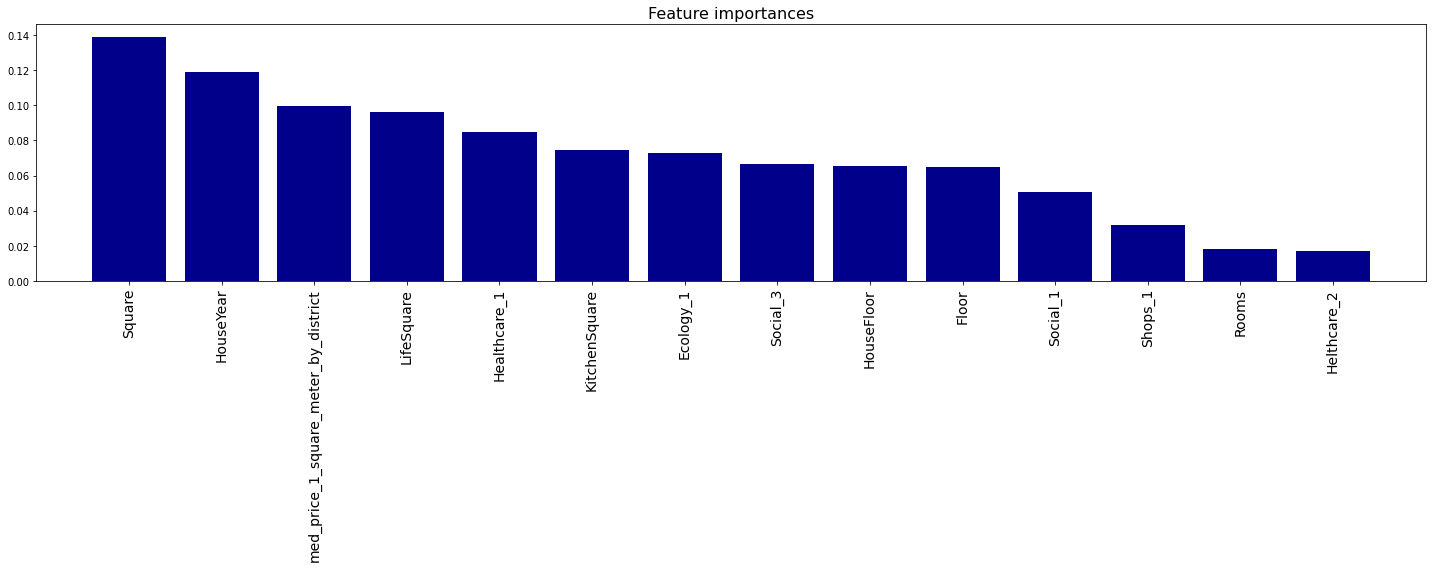

In [16]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[:-50:-1]

    plt.figure(figsize = (20, 8))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(len(indices)), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(len(indices)), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, len(indices)])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X_train)

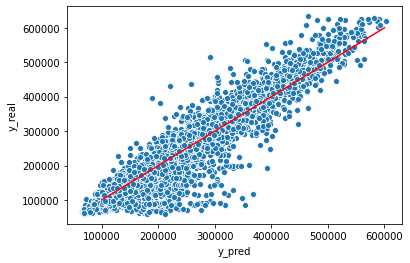

In [17]:
sns.scatterplot(model.predict(X_train), y_train)
plt.xlabel('y_pred')
plt.ylabel('y_real')
plt.plot([x for x in range(100000, 600000)], [x for x in range(100000 ,600000)], c='r')

In [18]:
useful_features = X_train.columns[np.argsort(model.feature_importances_)[:-21:-1]]
#X_train = X_train[useful_features]
#X_test = X_test[useful_features]

### Fitting macroparameters

In [19]:
parameters = {
    'n_estimators': [150 ,250, 300, 350],
    'max_depth': np.arange(5, 10),
    'random_state': [42],
    'min_samples_leaf': [10]
}

clf = GridSearchCV(
    estimator=LGBMRegressor(),
    param_grid=parameters,
    scoring='r2',
    cv=5
)

In [20]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                         'min_samples_leaf': [10],
                         'n_estimators': [150, 250, 300, 

In [21]:
cv_results = pd.DataFrame(clf.cv_results_)
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'param_n_estimators',
       'param_random_state', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [22]:
param_columns = [
    column
    for column in cv_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score', 'std_test_score']

cv_results = (cv_results[param_columns + score_columns]
              .sort_values(by=score_columns, ascending=False))

cv_results.head(10)

,param_max_depth,param_min_samples_leaf,param_n_estimators,param_random_state,mean_test_score,std_test_score
8,7,10,150,42,0.744528,0.019213
12,8,10,150,42,0.744465,0.016844
9,7,10,250,42,0.743162,0.019349
16,9,10,150,42,0.742981,0.017225
1,5,10,250,42,0.742626,0.016624
10,7,10,300,42,0.742316,0.019084
4,6,10,150,42,0.742232,0.015678
0,5,10,150,42,0.742156,0.015902
2,5,10,300,42,0.742107,0.016971
13,8,10,250,42,0.742078,0.015961


## Appendix

eventual check data

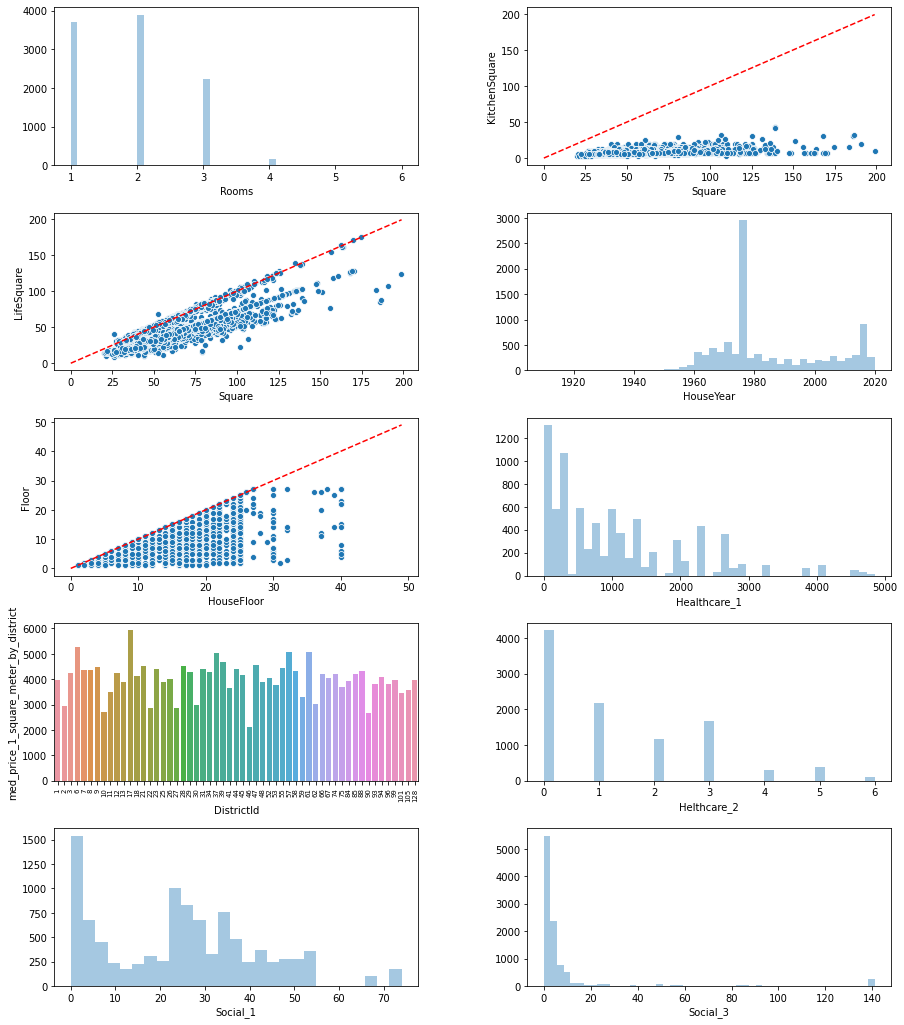

In [23]:
fig, ax = plt.subplots(5, 2)


fig.set_size_inches(15, 18)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

sns.distplot(X_train['Rooms'], ax = ax[0][0], kde=False)

sns.scatterplot(X_train['Square'], X_train['KitchenSquare'], ax = ax[0][1])
ax[0][1].plot(np.arange(0, 200), np.arange(0, 200), color = 'red', linestyle='--')

sns.scatterplot(X_train['Square'], X_train['LifeSquare'], ax = ax[1][0])
ax[1][0].plot(np.arange(0, 200), np.arange(0, 200), color = 'red', linestyle='--')

sns.distplot(X_train['HouseYear'], ax = ax[1][1], kde=False)

sns.scatterplot(X_train['HouseFloor'], X_train['Floor'], ax = ax[2][0])
ax[2][0].plot(np.arange(0, 50), np.arange(0, 50), color = 'red', linestyle='--')

sns.distplot(X_train.loc[~X_train['Healthcare_1'].isna(),'Healthcare_1'], ax = ax[2][1], kde=False)

X_train['DistrictId'] = df['DistrictId'].copy()
s = sns.barplot(list(set(X_train.loc[~X_train['med_price_1_square_meter_by_district'].isna(),'DistrictId'])), list(set(X_train.loc[~X_train['med_price_1_square_meter_by_district'].isna(),'med_price_1_square_meter_by_district'])), ax=ax[3][0])
s.set_xticklabels(s.get_xticklabels(), rotation=90, size='x-small')
s.set_xlabel('DistrictId')
s.set_ylabel('med_price_1_square_meter_by_district')

sns.distplot(X_train['Helthcare_2'], ax = ax[3][1], kde=False)

sns.distplot(X_train['Social_1'], ax = ax[4][0], kde=False)

sns.distplot(X_train['Social_3'], ax = ax[4][1], kde=False)

plt.show()

In [24]:
total = X_test.isnull().sum().sort_values(ascending=False)
percentage = (X_test.isnull().sum()/X_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Persent'])
missing_data.head(10)

,Total,Persent
med_price_1_square_meter_by_district,1235,0.2470
Healthcare_1,911,0.1822
Helthcare_2,0,0.0000
Rooms,0,0.0000
Shops_1,0,0.0000
Floor,0,0.0000
Social_1,0,0.0000
Ecology_1,0,0.0000
Social_3,0,0.0000
HouseFloor,0,0.0000


In [25]:
total = X_train.isnull().sum().sort_values(ascending=False)
percentage = (X_train.isnull().sum()/X_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Persent'])
missing_data.head()

,Total,Persent
med_price_1_square_meter_by_district,2354,0.2354
Healthcare_1,1884,0.1884
DistrictId,0,0.0000
Helthcare_2,0,0.0000
Rooms,0,0.0000
